In [5]:
#Nipun Chhajed
import pandas as pd
from datetime import datetime
import numpy as np
from scipy.optimize import fsolve, least_squares
import math
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import scipy.stats as st
from sklearn.linear_model import LinearRegression

In [6]:
np.set_printoptions(formatter = {'float_kind':'{:f}'.format}, suppress=True)
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Retreiving Data

In [7]:
#Reading prices data
price_list = pd.read_csv("prices_S&P.csv")

In [8]:
price_list

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2022-01-03,156.48000000,18.75000000,236.78000000,182.01000000,135.42000000,132.62000000,139.04000000,44.55000000,407.21000000,...,87.77000000,67.94000000,63.54000000,56.89000000,116.89000000,136.53000000,129.13000000,583.90000000,64.24000000,234.03000000
1,2022-01-04,151.19000000,19.02000000,237.05000000,179.70000000,135.16000000,131.36000000,135.77000000,45.13000000,404.30000000,...,87.49000000,68.37000000,65.93000000,57.18000000,118.13000000,137.26000000,130.44000000,587.60000000,66.07000000,225.12000000
2,2022-01-05,148.60000000,18.68000000,236.45000000,174.92000000,135.87000000,132.50000000,135.16000000,44.60000000,397.18000000,...,84.25000000,69.04000000,66.75000000,56.26000000,116.52000000,135.52000000,130.01000000,558.18000000,66.22000000,216.56000000
3,2022-01-06,149.12000000,18.57000000,241.65000000,172.00000000,135.23000000,130.45000000,135.14000000,44.86000000,378.00000000,...,84.64000000,68.50000000,68.32000000,56.22000000,116.36000000,136.92000000,128.93000000,555.16000000,68.94000000,217.42000000
4,2022-01-07,145.15000000,19.28000000,238.09000000,172.17000000,134.88000000,133.12000000,135.56000000,45.07000000,370.75000000,...,84.55000000,69.10000000,68.88000000,56.40000000,115.43000000,135.35000000,128.15000000,530.86000000,70.09000000,211.09000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2022-12-23,149.23000000,12.71000000,143.28000000,131.86000000,163.10000000,170.01000000,108.18000000,63.38000000,266.09000000,...,80.72000000,70.93000000,108.68000000,31.83000000,109.73000000,128.90000000,126.69000000,248.22000000,48.45000000,145.76000000
247,2022-12-27,149.55000000,12.53000000,145.02000000,130.03000000,162.99000000,169.00000000,108.57000000,63.62000000,265.31000000,...,84.33000000,71.57000000,110.19000000,32.07000000,110.72000000,129.90000000,127.28000000,251.00000000,48.84000000,145.30000000
248,2022-12-28,148.09000000,12.32000000,145.30000000,126.04000000,162.23000000,167.36000000,107.83000000,62.60000000,263.12000000,...,80.09000000,70.57000000,108.38000000,30.98000000,108.94000000,129.31000000,125.99000000,246.84000000,47.97000000,143.83000000
249,2022-12-29,151.09000000,12.70000000,146.31000000,129.61000000,162.56000000,166.05000000,110.31000000,63.11000000,268.38000000,...,81.26000000,71.07000000,109.20000000,32.28000000,111.64000000,129.99000000,127.83000000,257.53000000,49.08000000,148.15000000


In [9]:
#230 is price for 1st December. So we have 230 data points to make predictions 
price_list.iloc[230]

Date     2022-12-01
A      156.12000000
AAL     13.98000000
AAP    151.30000000
AAPL   148.31000000
           ...     
YUM    129.19000000
ZBH    123.35000000
ZBRA   268.82000000
ZION    51.99000000
ZTS    156.64000000
Name: 230, Length: 505, dtype: object

#Euler method to find coefficents 

Equation: $g(t,y) = \sum_{i=0}^{7}{a_i}{y(t)^i} + {y(t)}^{a_8}N(0, 1)$

Time series Data: $y_{0},y_{1},..,y_{n}$ at $t_{0},t_{1},..,t_{n}$ where n = 251 days 

Coefficients to estimate: $a_{0},a_{1},..,a_{8}$

We need number of observations, n >= 9 for estimation. However, I discover that the results are better when n gets larger. 

In [10]:
#Train mdoel for a stock

def train(stock, n):
  Data_A = price_list[stock].to_list()
  mu = np.mean(Data_A)
  sigma = np.std(Data_A)
  Data_A = (Data_A - mu) / sigma

  #Use first n data points to form system of non-linear equations

  #Forward Euler Method; taking h = 1 (difference between stock price data is 1 day)

  delta_y = [Data_A[230-n + i] - Data_A[230-n + i-1] for i in range(1, n)]
  wn = np.random.normal(0,1,365)

  #Using fsolve which is based on Gauss-Newton method
  def equations(vars):
      A = vars
      eqs = []
      for i in range(n-1):
        e = 0
        #e += A[0] + A[1] * Data_A[230-n+i-1] + A[2] * Data_A[230-n+i-1] ** 2 + A[3] * Data_A[230-n+i-1] ** 3 + A[4] * Data_A[230-n+i-1] ** 4 
        #e += A[5] * Data_A[230-n+i-1] ** 5 + A[6] * Data_A[230-n+i-1] ** 6 + A[7] * Data_A[230-n+i-1] ** 7 
        #e += Data_A[230-n+i-1] ** A[8] * wn[i] 
        e += A[0] * Data_A[230-n+i-1] - Data_A[230-n+i-1] ** 3
        e += A[1] * wn[i]
        
        e -= delta_y[i]
        eqs.append(e) 
      return eqs

  coefficients =  fsolve(equations, [0]*(n-1))
  return Data_A, coefficients, mu, sigma

In [11]:
#Using found coefficients to predict chosen stock's price at t = 230 (1st December 2022)
def predict_forward_Runge_Kutta(t, Data_A, coefficients, mu, sigma, stock, h=0.2):
  y_n = Data_A[t]

  #Runge Kutta
  for i in range(int(1/h)):
    wn = np.random.normal(0,1,365)

    #k1:
    dy = 0
    dy += coefficients[0] * y_n - y_n ** 3
    dy += coefficients[1] * wn[0]
    
    #k2:
    y_i_plus_half = y_n + (h/2)*dy
    dy_2 = 0
    dy_2 += coefficients[0] * y_i_plus_half - y_i_plus_half ** 3
    dy_2 += coefficients[1] * wn[1]
    
    #k3:
    y_i_minus1_plus2 = y_n - h*dy + 2*h*dy_2
    dy_3 = 0
    dy_3 += coefficients[0] * y_i_minus1_plus2 - y_i_minus1_plus2 ** 3
    dy_3 += coefficients[1] * wn[2]

    y_predicted = y_n + (h/6)*(dy + 4*dy_2 + dy_3)
    y_n = y_predicted

  y_predicted = (sigma * y_predicted) + mu
  y_true = sigma * Data_A[t+1] + mu
  error = np.abs(y_predicted-y_true) / y_true
 
  if float(error) > 2:
    print(stock)
    print(coefficients[0:5])
    print('y_n', y_n)
    print('dy_1', dy) 
    print('dy_2', dy_2)
    print('dy_3', dy_3)
    print('k2_y', y_i_plus_half)
    print('k3_y', y_i_minus1_plus2)
    print(y_predicted, y_true, '\n')  
  # print("Predicted stock price at t+1:" + str(y_predicted))
  # print("Actual stock price at t+1:" + str(Data_A[230]))
  return float(y_predicted), float(y_true), float(error)

In [12]:
#Function to Run Prediction Simulation
def run_predict(stock, t, h=0.2):
  n = 50 # number of day to estimate the parametrs
  Data_A, coefficients, mu, sigma = train(stock, n)
  return predict_forward_Runge_Kutta(t, Data_A, coefficients, mu, sigma, stock, h)

The number of parameters does not change: 8 parameters in total

In [13]:
#Apple Stock Error Graph
print(run_predict('AAPL', 229))
print(run_predict('AAPL', 50))
print(run_predict('AAPL', 100))
print(run_predict('AAPL', 150))
print(run_predict('AAPL', 200))

(142.9066567832196, 148.31, 0.03643276391868653)
(165.13519952032684, 160.62, 0.028111066618894478)
(141.48627900780113, 149.64, 0.0544889133400084)
(167.99019744870125, 169.24, 0.007384794087087903)
(141.66987303672946, 143.39, 0.01199614312902246)


/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# Run Simulation

Final method to run price prediction and accuracy simulation on all stocks of the S&P 500. Method stores results in a dictionary with key as stock, and actual price for 12/01/2022, predicted price for 12/01/2022, relative  error as values.

In [14]:
final_outputs = {}
stock_list = price_list.columns[1:][:]

In [15]:
run_predict('GIS', 230)

(80.54261244795765, 86.52, 0.06908677244616672)

In [16]:
#For all stocks saves results tuple in final_outputs dictionary
def run_simulation(stock_list, t, h=0.2):
  for stock in stock_list:
    final_prediction, actual, error = run_predict(stock, t, h)
    #confidence_interval = confidenceInterval(results, 0.80)
    #final_outputs[stock] = (actual, final_prediction, error, confidence_interval)
    final_outputs[stock] = (actual, final_prediction, error)

Here, we choose an appropriate step-size for the RK3 Model and use the one with the lowest error as our final model

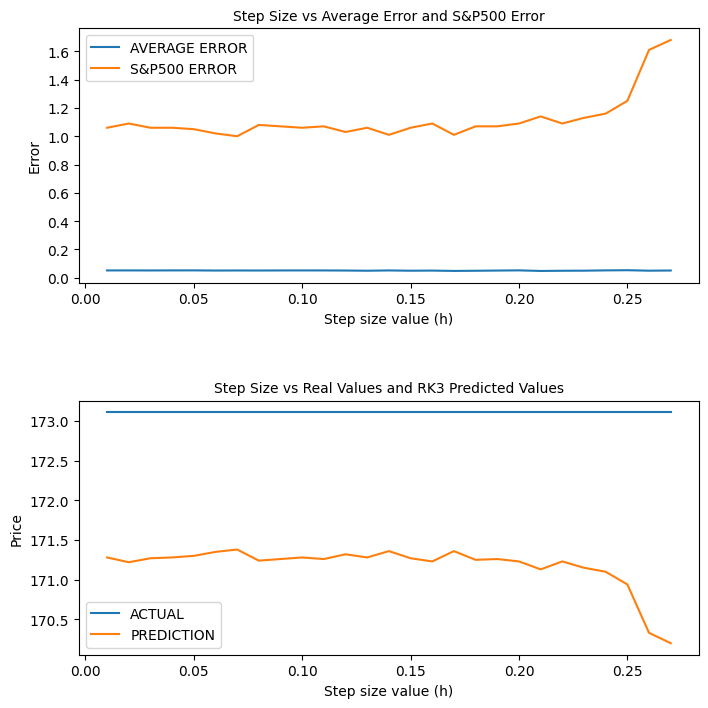

In [48]:
def differentStepSizeGraphRK3():
  avg_error = []
  sp_error = []
  predicted = []
  real = []
  hs = np.linspace(0,0.28,28,endpoint=False)[1:]

  for h in hs:
    run_simulation(price_list.columns[1:][:], 229, h)
    errors = [a[2] for a in list(final_outputs.values())]
    y_true = [a[0] for a in list(final_outputs.values())]
    y_pred = [a[1] for a in list(final_outputs.values())]

    Error = round(np.mean(errors),4)
    avg_error.append(Error)
    SPReal = round(np.mean(y_true), 2)
    real.append(SPReal)

    SPPredicted = round(np.mean(y_pred), 2)
    predicted.append(SPPredicted)

    SPError = round(abs((SPReal-SPPredicted)*100/SPReal), 2)
    sp_error.append(SPError)

  fig, ax = plt.subplots(2, 1, figsize=(8, 8))
  ax[0].plot(hs, avg_error, label='AVERAGE ERROR')
  ax[0].plot(hs, sp_error, label='S&P500 ERROR')
  ax[1].plot(hs, real, label='ACTUAL')
  ax[1].plot(hs, predicted, label='PREDICTION')

  ax[0].set_xlabel('Step size value (h)')
  ax[0].set_ylabel('Error')
  font1 = {'color':'black','size':10}
  ax[0].set_title("Step Size vs Average Error and S&P500 Error", fontdict = font1)
  ax[0].legend(loc = 'upper left')

  ax[1].set_xlabel('Step size value (h)')
  ax[1].set_ylabel('Price')
  font1 = {'color':'black','size':10}
  ax[1].set_title("Step Size vs Real Values and RK3 Predicted Values", fontdict = font1)
  ax[1].legend(loc = 'lower left')

  fig.tight_layout(pad=4.0)
  plt.show()

  return avg_error, sp_error

avg_error, sp_error = differentStepSizeGraphRK3()

In [49]:
#Index for finding best model
print("Best step size for minimum average error: ", (np.argmin(np.array(avg_error)+1)*0.01))
print("Best step size for minimum S&P error: ", (np.argmin(np.array(sp_error)+1)*0.01))

Best step size for minimum average error:  0.2
Best step size for minimum S&P error:  0.06


In [39]:
run_simulation(price_list.columns[1:][:], 229, 0.2)

In [40]:
#Save results in a pickle file
with open('results_runge.pkl', 'wb') as f:
  pickle.dump(final_outputs, f)
  print("saved values")

saved values


In [41]:
len(final_outputs)

504

In [42]:
#Load results from pickle file
with open('results_runge.pkl', 'rb') as f:
  results_runge = pickle.load(f)
  print("success")
len(results_runge)

success


504

## Visualize S&P 500: Real and Predicted values

1. The first graph shows the real vs predicted values for n stocks from the S&P 500
2. The second graph shows the real vs predicted equally weigthed average price of the index, along with relative error

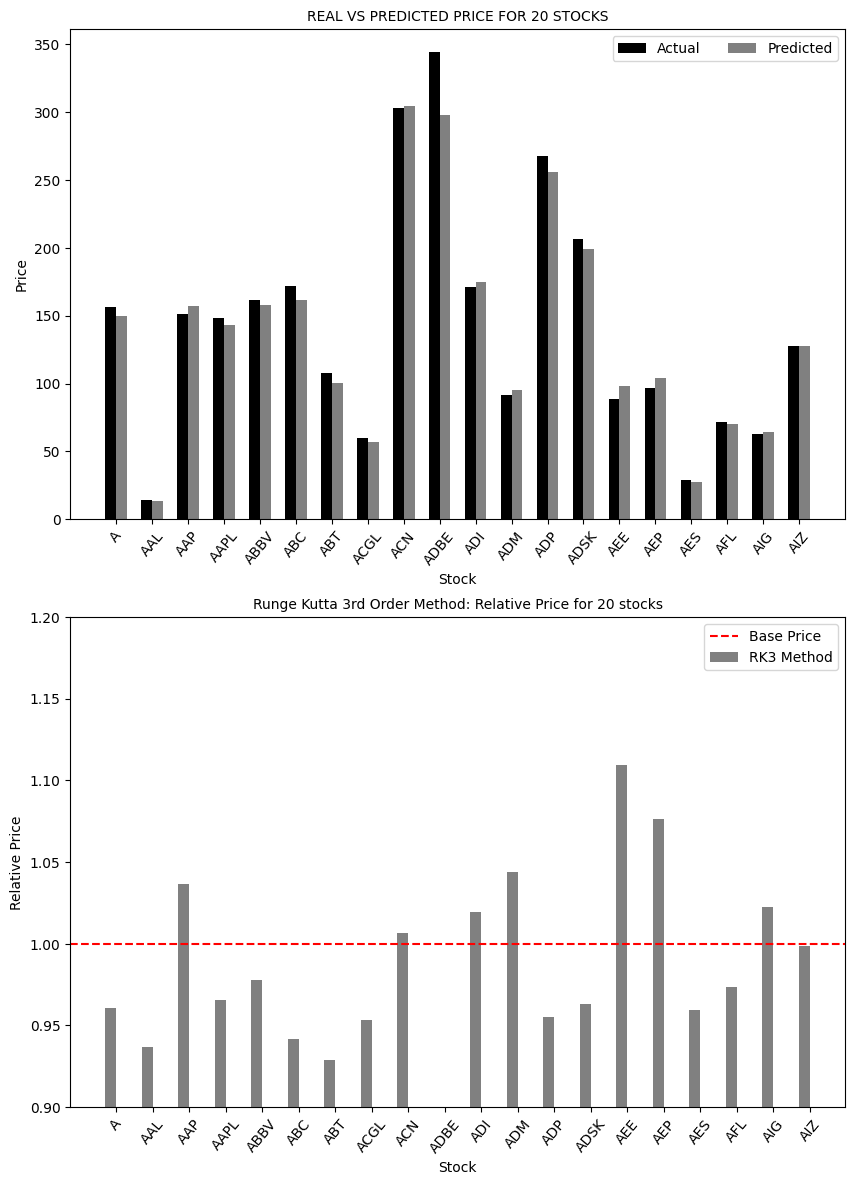

In [43]:
def stock_price_graph(results, n):

  ind = np.arange(n)
  x = np.array(list(results.keys())[:n])
  y_true = np.array([a[0] for a in list(results.values())[:n]])
  y_pred = np.array([a[1] for a in list(results.values())[:n]])

  fig, ax = plt.subplots(2, 1, figsize=(10, 14))
  ax[0].bar(ind, y_true, 0.3, color='black', label='Actual')
  ax[0].bar(ind+0.3, y_pred, 0.3, color='grey', label='Predicted')

  ax[0].set_xticks(ind + 0.3 / 2, x)

  ax[0].set_xlabel('Stock')
  ax[0].set_ylabel('Price')
  ax[0].legend(loc='upper right', ncols=2)
  plt.setp(ax[0].get_xticklabels(), rotation=50, horizontalalignment='center')
  plt.setp(ax[1].get_xticklabels(), rotation=50, horizontalalignment='center')
  font1 = {'color':'black','size':10}
  ax[0].set_title("REAL VS PREDICTED PRICE FOR 20 STOCKS", fontdict = font1)


  ax[1].set_xticks(ind + 0.3 / 2, x)
  ax[1].bar(ind, y_pred/y_true, 0.3, color='grey', label='RK3 Method')
  ax[1].set_ylim(ymax = 1.2, ymin = 0.9) 
  ax[1].set_xlabel('Stock')
  ax[1].set_ylabel('Relative Price')
  ax[1].legend(loc='upper right', ncols=2)
  ax[1].axhline(1, color='red', label = "Base Price", linestyle='--')
  ax[1].legend(loc = 'upper right')
  ax[1].set_title("Runge Kutta 3rd Order Method: Relative Price for 20 stocks", fontdict = font1)

  plt.show()

stock_price_graph(results_runge, 20)

[150.0293442667833, 13.095138556591042, 156.8699133005964, 143.1800318358809, 158.03519390077616, 161.6359666958074, 100.2534999580673, 56.96168775299422, 304.815131593888, 298.08825550923, 174.78972874861236, 95.31647993443575, 255.9392595722487, 199.3050776485407, 98.41143444496664, 103.83939905209108, 27.552348674505872, 69.9942700653822, 64.51860908804986, 127.81341371760223, 193.2960759759643, 86.29816111587016, 294.6294723713263, 198.73414185111287, 46.215414490498894, 133.98970629467166, 122.8344343658439, 108.48059060414168, 13.045632311662814, 62.99525113458294, 139.34595142687445, 283.1235673116753, 321.64761047174824, 196.53357953380782, 95.70408356942951, 132.72159137663274, 227.16809631997586, 303.8452527992724, 57.85882960849343, 47.053085079148715, 293.721444147634, 79.30514148364533, 106.6438554912926, 142.59706950228696, 122.35485285129117, 72.822824044017, 171.6344955787247, 625.5685342673019, 191.84148092676082, 160.93754827028278, 149.46193301185633, 2487.8170268038

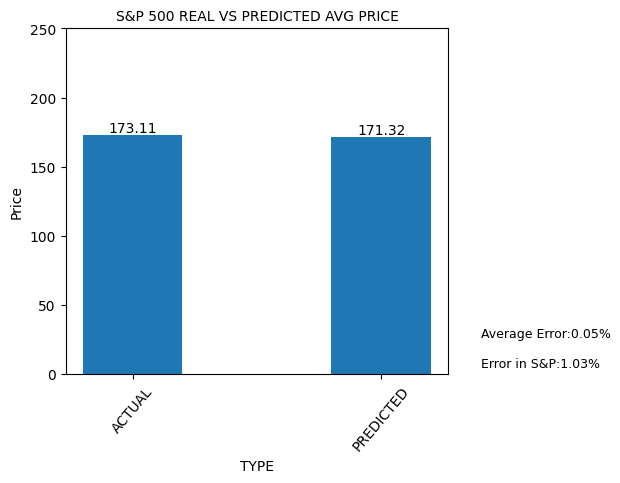

In [44]:
def average_price_graph(results_loaded):

  #Average S&P 500 Error
  errors = [a[2] for a in list(results_loaded.values())]
  y_true = [a[0] for a in list(results_loaded.values())]
  y_pred = [a[1] for a in list(results_loaded.values())]

  print(y_pred)
  Error = round(np.mean(errors),2)
  SPReal = round(np.mean(y_true), 2)
  SPPredicted = round(np.mean(y_pred), 2)
  print(SPPredicted)
  SPError = round(abs((SPReal-SPPredicted)*100/SPReal), 2)

  ind = np.arange(2)
  fig, ax = plt.subplots()
  plt.ylim(top=250)
  bars = ax.bar(ind, [SPReal, SPPredicted], width = 0.4)
  plt.xticks(ind, ["ACTUAL", "PREDICTED"])
  ax.bar_label(bars) 

  ax.set_xlabel('TYPE')
  ax.set_ylabel('Price')
  plt.text(1.4, 5, 'Average Error:%s'%(Error)+"%" + '\n\nError in S&P:%s'%(SPError)+"%", fontsize = 9)
  plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')
  plt.tight_layout()

  font1 = {'color':'black','size':10}


  plt.title("S&P 500 REAL VS PREDICTED AVG PRICE", fontdict = font1)
  plt.show()

average_price_graph(results_runge)

# Comparison with linear regression

## Choosing appropriate number of data points, n
Here, we compare the average error of our model to a baseline model based on linear regression using past n data points to predict stock prices on 12/1/2022.

1. First plot is between errors in prediction vs n
2. Second plot shows predicted prices for different n as well as the actual price for the stock

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


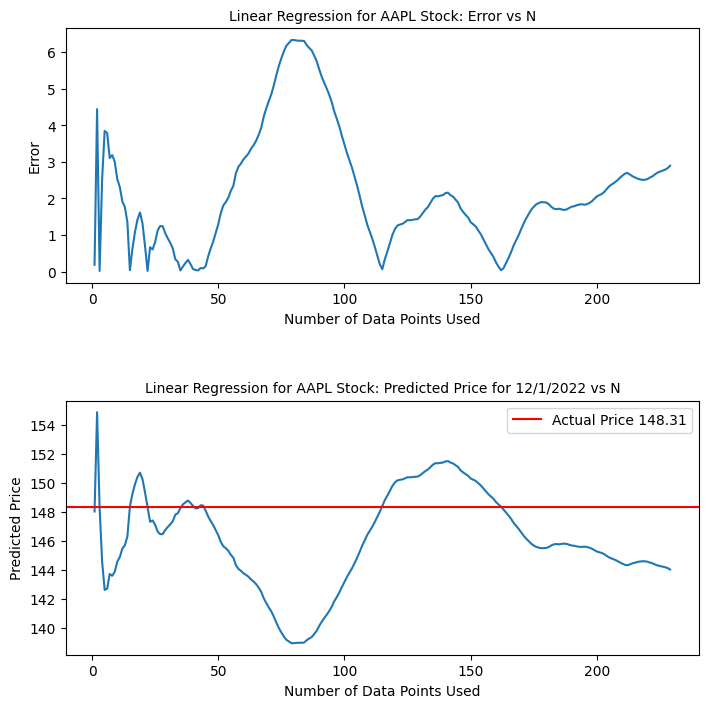

In [45]:
#Using Sklearn Linear Regression Model using past n data point 
def linearRegressionPredictor(stock, n):
  data = price_list[stock].to_list()
  X = np.arange(n).reshape(-1, 1)
  y = [data[230 - n + i] for i in range(n)]
  reg = LinearRegression().fit(X, y)
  score = reg.score(X, y)
  prediction = round(reg.predict(np.array([n]).reshape(-1, 1))[0], 2)
  actual = price_list[stock].to_list()[230]
  error = abs((prediction - actual)*100/actual)
  return prediction, error, score


def linearRegressionErrorGraph(stock):

  x = np.arange(1, 230)
  price_results = []
  error_results = []
  score_results = []
  for i in range(1, 230):
    prediction, error, score = linearRegressionPredictor(stock, i)
    price_results.append(prediction)
    error_results.append(error)
    score_results.append(score)


  real_price = price_list[stock].to_list()[230]
  fig, ax = plt.subplots(2, 1, figsize=(8, 8))
  ax[0].plot(x, error_results)
  ax[1].plot(x, price_results)


  ax[0].set_xlabel('Number of Data Points Used')
  ax[0].set_ylabel('Error')
  font1 = {'color':'black','size':10}
  ax[0].set_title("Linear Regression for %s" %(stock) + " Stock" + ": Error vs N", fontdict = font1)

  ax[1].set_xlabel('Number of Data Points Used')
  ax[1].set_ylabel('Predicted Price')
  font1 = {'color':'black','size':10}
  ax[1].set_title("Linear Regression for %s" %(stock) + " Stock:" + " Predicted Price for 12/1/2022 vs N", fontdict = font1)
  ax[1].axhline(real_price, 0, 230, color='red', label = "Actual Price %s" %(real_price))
  ax[1].legend(loc = 'upper right')

  fig.tight_layout(pad=4.0)
  plt.show()

  return price_results, error_results, score_results

price_results, error_results, score_results = linearRegressionErrorGraph("AAPL")

## Comparison Graphs

We notice that with greater number of data points, error is increasing due to overfitting. Thus, we decide to stick to n = 10 data points in line with Euler's method where we use 0 < M & N < 10.

1. We plot stock price graphs showing linear regression price and Euler's method predicted price. The scale is chosen as relative by dividing the price by the actual price of the stock.

2. We plot the price of an equally weighted S&P 500 portfolio and report the errors.


In [24]:
results_LR = {}
def linearRegressionResults(n):
  for stock in stock_list:
    results_LR[stock] = linearRegressionPredictor(stock, n)

linearRegressionResults(10)

In [25]:
#Save results in a pickle file
with open('results_LR.pkl', 'wb') as f:
  pickle.dump(results_LR, f)
  print("saved values")

saved values


In [26]:
#Load results from pickle file
with open('results_LR.pkl', 'rb') as f:
  results_LR = pickle.load(f)
  print("success")
len(results_LR)

success


504

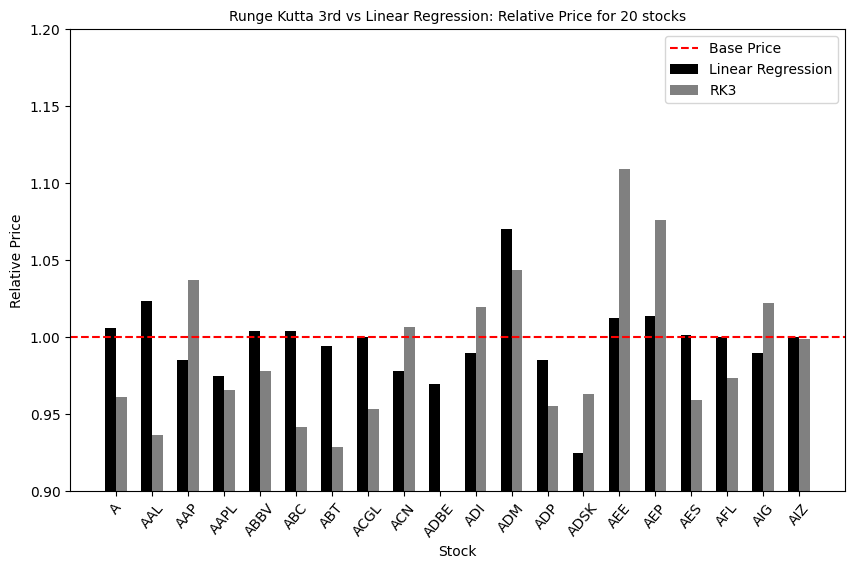

In [46]:
def stock_price_graph(results_Euler, results_LR, n):

  ind = np.arange(n)
  x = np.array(list(results_Euler.keys())[:n])
  y_true = np.array([a[0] for a in list(results_Euler.values())[:n]])
  y_pred_Euler = np.array([a[1] for a in list(results_Euler.values())[:n]]) / y_true
  y_pred_LR = np.array([a[0] for a in list(results_LR.values())[:n]]) / y_true

  y_true =  np.array([1 for i in range(n)])

  fig, ax = plt.subplots(figsize=(10, 6))
  # ax.bar(ind, y_true, 0.3, color='grey', label='Actual')
  ax.bar(ind, y_pred_LR, 0.3, color='black', label='Linear Regression')
  ax.bar(ind+0.3, y_pred_Euler, 0.3, color='grey', label='RK3')


  plt.ylim(ymax = 1.2, ymin = 0.9) 
  plt.xticks(ind + 0.3 / 2, x)

  ax.set_xlabel('Stock')
  ax.set_ylabel('Relative Price')
  ax.legend(loc='upper right', ncols=2)

  ax.axhline(1, color='red', label = "Base Price", linestyle='--')
  ax.legend(loc = 'upper right')

  plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')

  font1 = {'color':'black','size':10}
  plt.title("Runge Kutta 3rd vs Linear Regression: Relative Price for 20 stocks", fontdict = font1)

  plt.show()

stock_price_graph(results_runge, results_LR, 20)

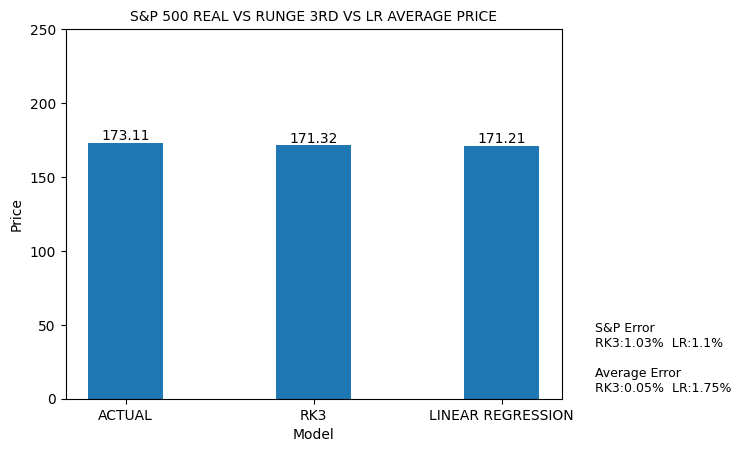

In [47]:
def average_price_graph(results_Euler, results_LR):

  #Average S&P 500 Error
  errors_euler = [a[2] for a in list(results_Euler.values())]
  y_true = [a[0] for a in list(results_Euler.values())]
  y_euler = [a[1] for a in list(results_Euler.values())]
  y_lr = [a[0] for a in list(results_LR.values())]
  errors_LR = [a[1] for a in list(results_LR.values())]

  Error_Euler = round(np.mean(errors_euler),2)
  Error_LR = round(np.mean(errors_LR),2)

  SPReal = round(np.mean(y_true), 2)
  SPEuler = round(np.mean(y_euler), 2)
  SPLR = round(np.mean(y_lr), 2)

  SPErrorEuler = round(abs((SPReal-SPEuler)*100/SPReal), 2)
  SPErrorLR = round(abs((SPReal-SPLR)*100/SPReal), 2)

  ind = np.arange(3)
  fig, ax = plt.subplots()
  plt.ylim(top=250)
  bars = ax.bar(ind, [SPReal, SPEuler, SPLR], width = 0.4)
  plt.xticks(ind, ["ACTUAL", "RK3", "LINEAR REGRESSION"])
  ax.bar_label(bars) 

  ax.set_xlabel('Model')
  ax.set_ylabel('Price')
  plt.text(2.5, 5, 'S&P Error\nRK3:%s'%(SPErrorEuler)+"%  " + 'LR:%s'%(SPErrorLR)+"%" + '\n\nAverage Error\nRK3:%s'%(Error_Euler)+"%  " + 'LR:%s'%(Error_LR)+"%", fontsize = 9)
  # plt.tight_layout()

  font1 = {'color':'black','size':10}


  plt.title("S&P 500 REAL VS RUNGE 3RD VS LR AVERAGE PRICE", fontdict = font1)
  plt.show()

average_price_graph(results_runge, results_LR)